# Capstone 1 : NN2

# Medical Image Analysis with CNN

# Define Project Objectives

In this project, 

you will build a Convolutional Neural Network (CNN) model that can analyze medical images, such as X-rays or MRIs, to detect diseases or abnormalities. 

You will start by exploring a dataset of medical images, such as the Chest X-Ray Images dataset or the NIH Clinical Center dataset, and performing EDA to gain insights into the data. 

You will analyze the correlation between different features and identify any outliers or missing values that need to be handled.

You will then `preprocess the dataset`, `splitting it into training and testing sets`, and `normalizing the pixel values`. 

You will `build a CNN model` using PyTorch or `Tensorflow` that can analyze the input medical images and `detect diseases or abnormalities`. 

You will experiment with different neural network architectures, `activation functions`, and `learning rates` to find the best model for the task.

Finally, you will evaluate the performance of your model using metrics such as `accuracy`, `precision`, `recall`, and `F1 score`, and visualize the results using `confusion matrices` or other visualization techniques to see how well the model performs on different medical conditions.

Dataset URL:

`Chest X-Ray Images` dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The Chest X-Ray Images dataset contains `5856 images` with binary classes: `normal or pneumonia`.

`NIH Clinical Center` dataset: https://nihcc.app.box.com/v/ChestXray-NIHCC

The NIH Clinical Center dataset contains over `100,000 chest X-ray images` with `14 different disease labels`.

This project will give you hands-on experience with CNN and medical image analysis, and will help you develop skills in coding with PyTorch and Tensorflow. 

It will also give you the opportunity to experiment with different neural network architectures and activation functions to find the best model for the task.

# Data Acquisition

In [54]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
import keras.backend as K
from keras.models import Model

from keras.layers import LeakyReLU, Activation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [43]:
os.getcwd()

'd:\\Projects\\Medical Image Analysis with CNN'

Create subplots and Loop through train, val, and test sets

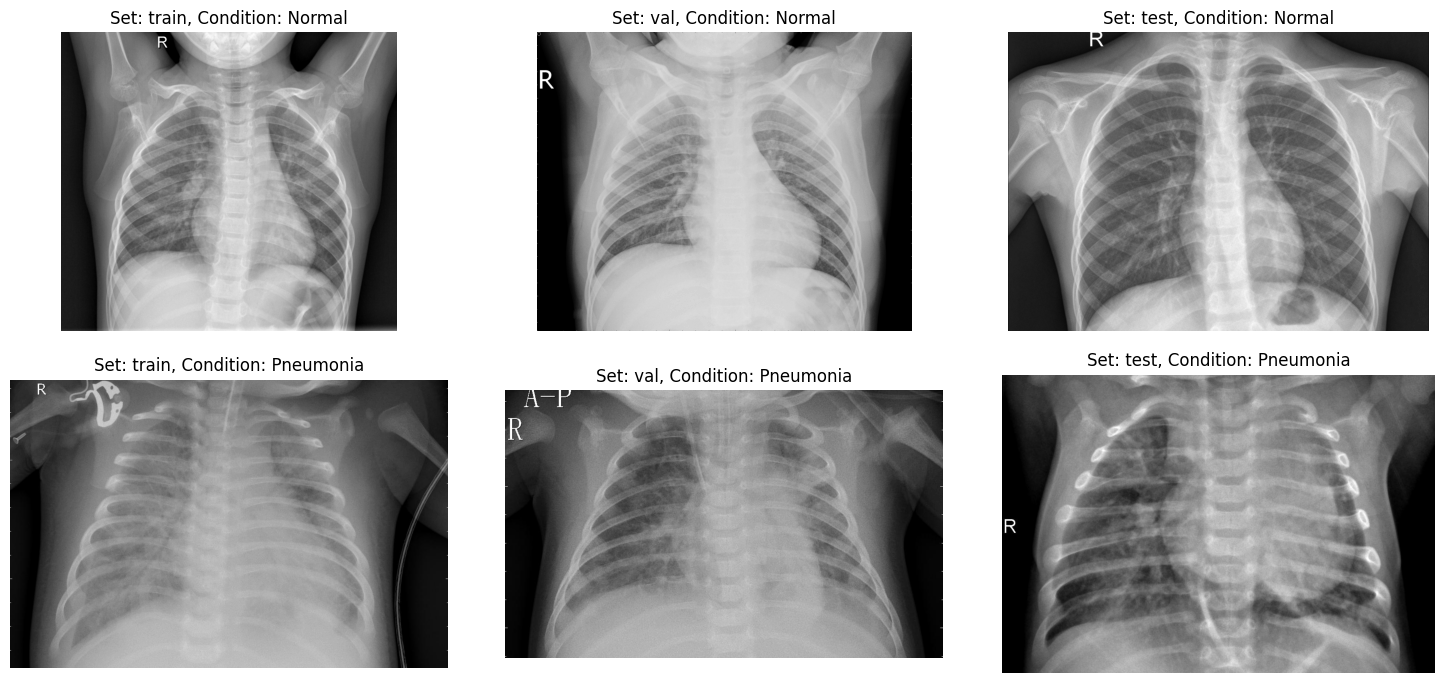

In [31]:
def show_data(input_path):
    fig, ax = plt.subplots(2, 3, figsize = (15,7))
    ax= ax.ravel()
    plt.tight_layout()

    for i, _set in enumerate(['train', 'val', 'test']):
        set_path = os.path.join(input_path, _set) # "chest_xray/train" or "chest_xray/val" or "chest_xray/test"
        # print(set_path)
        normal_img_path = os.path.join(set_path, 'NORMAL', os.listdir(os.path.join(set_path, 'NORMAL'))[0])
        pneumonia_img_path = os.path.join(set_path, 'PNEUMONIA', os.listdir(os.path.join(set_path, 'PNEUMONIA'))[0])
        
        if os.path.isfile(normal_img_path) and os.path.isfile(pneumonia_img_path):
            # Normal 
            ax[i].imshow(plt.imread(normal_img_path), cmap='gray')
            ax[i].set_title(f'Set: {_set}, Condition: Normal')
            ax[i].axis('off')
            # Pneumonia
            ax[i+3].imshow(plt.imread(pneumonia_img_path), cmap='gray')
            ax[i+3].set_title(f'Set: {_set}, Condition: Pneumonia')
            ax[i+3].axis('off')
        else:
            print(f"Image not found for {_set} set")

    plt.show()

base_dir = "chest_xray/"
show_data(base_dir)

In [32]:
for _set in ['train', 'val', 'test']:
    no_normal = len(os.listdir(base_dir + _set + '/NORMAL'))
    no_pneumonia = len(os.listdir(base_dir + _set + '/PNEUMONIA'))
    print(f"Set: {_set}, normal images: {no_normal}, pneumonia images: {no_pneumonia}")

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


# Data Preprocessing:

In [38]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0 / 255, 
                                       zoom_range=0.3, 
                                       vertical_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    
    train_set = train_datagen.flow_from_directory(
        directory=base_dir + "/train",
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    test_set = test_datagen.flow_from_directory(
        directory=base_dir + "/test",
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(base_dir + 'test' + cond)):
            img = plt.imread(base_dir + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype(np.float32) / 255
            
            if cond == '/NORMAL/':
                label = 0
            else:
                label = 1
            
            test_data.append(img)
            test_labels.append(label)
    
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, test_set, test_data, test_labels

img_dims = 150
batch_size= 32
train_gen, test_gen, test_data, test_labels = process_data(img_dims=img_dims, batch_size=batch_size)
train_gen

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [39]:
test_gen

In [40]:
test_data

array([[[[0.14117648, 0.14117648, 0.14117648],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         ...,
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.13725491, 0.13725491, 0.13725491],
         [0.12941177, 0.12941177, 0.12941177]],

        [[0.11764706, 0.11764706, 0.11764706],
         [0.11764706, 0.11764706, 0.11764706],
         [0.11764706, 0.11764706, 0.11764706],
         ...,
         [0.11764706, 0.11764706, 0.11764706],
         [0.11372549, 0.11372549, 0.11372549],
         [0.12156863, 0.12156863, 0.12156863]],

        [[0.13333334, 0.13333334, 0.13333334],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         ...,
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ]],

        ...,

        [[0.12156863, 0.12156863, 0.12156863],
         [0.10588235, 0.10588235, 0.10588235]

In [41]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# CNN Model Architecture and Model Compilation:

In [49]:
def build_CNN_model(img_dims):
    model = models.Sequential()
    # firrst conv block
    model.add(layers.Conv2D(filters=16,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same',
                            input_shape=(img_dims, img_dims, 3)))
    model.add(layers.Conv2D(filters=16,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same')) 
    model.add(layers.MaxPooling2D(pool_size=(2,3)))
    model.add(layers.Dropout(0.25))
    
    # Second conv block
    model.add(layers.SeparableConv2D(filters=32,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same'))
    model.add(layers.SeparableConv2D(filters=32,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Third conv block
    model.add(layers.SeparableConv2D(filters=64,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same')) 
    model.add(layers.SeparableConv2D(filters=64,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Fourth conv block
    model.add(layers.SeparableConv2D(filters=128,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same')) 
    model.add(layers.SeparableConv2D(filters=128,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Fifth conv block
    model.add(layers.SeparableConv2D(filters=256,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same')) 
    model.add(layers.SeparableConv2D(filters=256,
                                     kernel_size=(3,3),
                                     activation='relu',
                                     padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=512,
                           activation='relu'))
    model.add(layers.Dropout(rate=0.7))
    model.add(layers.Dense(units=128,
                           activation='relu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=64,
                           activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    
    # output layer 
    model.add(layers.Dense(units=1,
                           activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_CNN_model(img_dims=img_dims)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 75, 50, 16)        0         
                                                                 
 separable_conv2d_8 (Separa  (None, 75, 50, 32)        688       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_9 (Separa  (None, 75, 50, 32)       

# Callbacks

In [50]:
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', 
                             save_best_only=True,
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max')

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

# Training the Model:

In [51]:
hist = model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=10,
    validation_data=test_gen,
    validation_steps=test_gen.samples // batch_size,
    callbacks=[checkpoint, reduce_lr]
)
hist

C:\Users\CENTER_ELRahama\AppData\Local\Temp\ipykernel_7764\546638673.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 337s 2s/step - loss: 0.4659 - accuracy: 0.7826 - val_loss: 0.6782 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 325s 2s/step - loss: 0.3036 - accuracy: 0.8671 - val_loss: 0.7570 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 346s 2s/step - loss: 0.2687 - accuracy: 0.8877 - val_loss: 1.6805 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 309s 2s/step - loss: 0.2702 - accuracy: 0.8880 - val_loss: 0.6568 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9089
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 325s 2s/step - loss: 0.2333 - accuracy: 0.9089 - val_loss: 1.2935 - val_accuracy: 0.6941 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 319s 

# Displaying Metrics for trian and val set

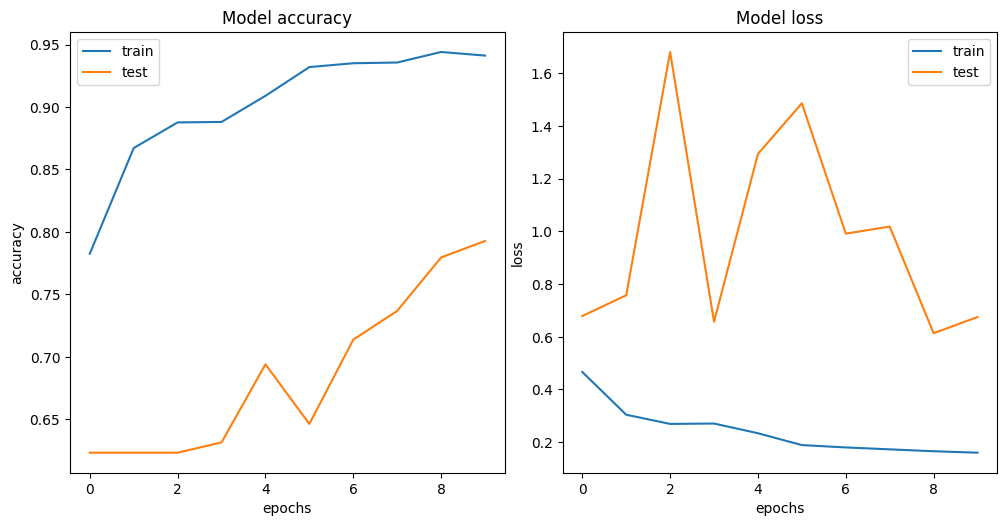

In [52]:
def show_metrics():
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax = ax.ravel()
    plt.tight_layout()

    for i, metr in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[metr])
        ax[i].plot(hist.history['val_' + metr])
        ax[i].set_title(f'Model {metr}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metr)
        ax[i].legend(['train', 'test'])

    plt.show()
    
show_metrics()

# Evaluation Metrics for test set

accuracy score

In [60]:
preds = model.predict(test_data)
test_acc = np.round(accuracy_score(test_labels, np.round(preds)) * 100, 2)
test_acc

20/20 [==============================] - 2s 122ms/step


86.38

In [61]:
train_acc = np.round((hist.history['accuracy'][-1] * 100, 2))[0]
train_acc

94.0

Classification report for Precision, Recall and F1-score

In [63]:
cr = classification_report(test_labels, np.round(preds))
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



Confusion matrix

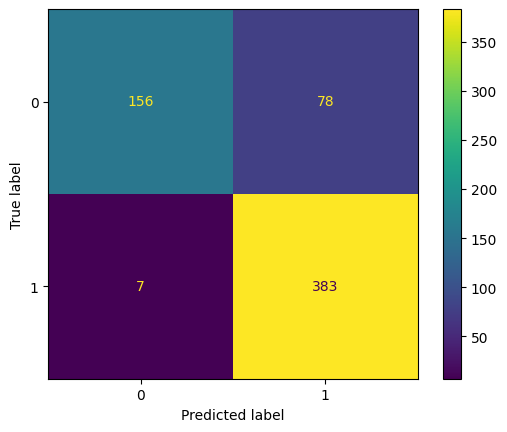

In [66]:
cm = confusion_matrix(test_labels, np.round(preds))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()